# Import Dependencies

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential 
import tensorflow as tf

from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

/Users/adamgrunwald/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Read pollution.csv into pandas df
- set date as index
- display first 5 rows
- the Air Pollution data is discussed here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- this is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
- we can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

In [2]:
!pip3 install influxdb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [3]:
from influxdb import DataFrameClient
import pandas as pd
db_name = 'smart_home_zukalovi'
dataframe_client = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )


In [73]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ
from tokenize import group


left_time_interval = pd.to_datetime('2023-12-29 00:00:00')
right_time_interval = pd.to_datetime('2024-3-05 00:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '5s'
tmp_output_water_entity_id = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2 = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id = 'esphome_web_c771e8_tmp3'
relay_entity_id = 'shelly1pm_84cca8b07eae'

queries = {
    "water_flow": {
        "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
        "measurement": "L/min",
    },
    "water_temperature": {
        "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "°C",
    },
    "temperature": {
        "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "state",
    },
    "humidity": {
        "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "state",
    },
    "wind_speed": {
        "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "state",
    },
    "presence": {
        "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
        "measurement": "state",
    },
    "boiler_water_temperature": {
        "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "°C",
    },
    "boiler_relay_status": {
        "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
        "measurement": "state",
    },
    "klara_longitude": {
        "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'klara_z_iphone\' GROUP BY time({group_by_time_interval}) FILL(linear)',
        "measurement": "state",
    },
    "klara_latitude": {
        "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'klara_z_iphone\' GROUP BY time({group_by_time_interval}) FILL(linear)',
        "measurement": "state",
    },
    
}

In [74]:
df_all_list = []
    # iterate over key an value in data
for key, value in queries.items():
    print("Querying: ", key, value["sql_query"])
    # get data from influxdb
    result = dataframe_client.query(value["sql_query"])[
        value["measurement"]
    ]

    df = pd.DataFrame(result)
    df_all_list.append(df)

df_concat = pd.concat(df_all_list, axis=1)
# save as pkl
with open('df_test.pkl', 'wb') as f:
    df_concat.to_pickle(f)

Querying:  water_flow SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "smart_home_zukalovi"."autogen"."L/min" WHERE time > '2023-12-29T00:00:00Z' AND time < '2024-03-05T00:00:00Z' GROUP BY time(5s) FILL(0)
Querying:  water_temperature SELECT mean("value") AS "water_temperature_mean" FROM "smart_home_zukalovi"."autogen"."°C" WHERE time > '2023-12-29T00:00:00Z' AND time < '2024-03-05T00:00:00Z' AND ("entity_id"='esphome_web_c771e8_ntc_temperature_b_constant' OR "entity_id"='esphome_web_c771e8_ntc_temperature_b_constant_2') GROUP BY time(5s) FILL(null)
Querying:  temperature SELECT mean("temperature") AS "outside_temperature_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-12-29T00:00:00Z' AND time < '2024-03-05T00:00:00Z' AND "domain"='weather' AND "entity_id"='domov' GROUP BY time(5s) FILL(null)
Querying:  humidity SELECT mean("humidity") AS "outside_humidity_mean" FROM "smart_home_zukalovi"."autogen"."state" WHERE time > '2023-12-29T00:00:00Z' AND time 

In [75]:
#load df form pkl
import pickle 
with open('df_test.pkl', 'rb') as f:
    df_concat = pickle.load(f)
    
    


In [181]:
print(df_concat)

                           water_flow_L_per_minute_mean  \
2023-12-29 00:00:00+00:00                           0.0   
2023-12-29 00:00:05+00:00                           0.0   
2023-12-29 00:00:10+00:00                           0.0   
2023-12-29 00:00:15+00:00                           0.0   
2023-12-29 00:00:20+00:00                           0.0   
...                                                 ...   
2024-03-04 23:59:35+00:00                           0.0   
2024-03-04 23:59:40+00:00                           0.0   
2024-03-04 23:59:45+00:00                           0.0   
2024-03-04 23:59:50+00:00                           0.0   
2024-03-04 23:59:55+00:00                           0.0   

                           water_temperature_mean  outside_temperature_mean  \
2023-12-29 00:00:00+00:00                    19.6                       NaN   
2023-12-29 00:00:05+00:00                     NaN                       NaN   
2023-12-29 00:00:10+00:00                    19.4     

In [195]:
from math import dist
from turtle import home
import numpy as np
from geopy.distance import geodesic
from haversine import haversine

home_latitude =49.4140378
home_longitude = 16.5161789
home_coords = (home_latitude, home_longitude)

def haversine_dist(x1,x2,y1,y2):
   return haversine((x1, x2) , (y1, y2), unit='km')

# Data Processing 


def calculate_distance(row):
    curr_coords = (row['mean_latitude'], row['mean_longitude'])
    distance = geodesic(home_coords, curr_coords).kilometers
    return geodesic(home_coords, curr_coords).kilometers


def extract_features_from_longitude_latitude(df, home_longitude, home_latitude):
    df['distance_from_home'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],home_latitude,home_longitude)

    df['heading_to_home'] = np.arctan2(df['mean_latitude'] - home_latitude, df['mean_longitude'] - home_longitude)
    df['heading_to_home_sin'] = np.sin(df['heading_to_home'])
    df['heading_to_home_cos'] = np.cos(df['heading_to_home'])
    # resample by 10m mean
    df['time_stamp'] = df.index
    # calculate the speed of device
    df['time_diff'] = df['time_stamp'].diff().dt.total_seconds() / 3600  # Convert seconds to hours
    df['distance'] = np.vectorize(haversine_dist)(df['mean_latitude'],df['mean_longitude'],df['mean_latitude'].shift(1),df['mean_longitude'].shift(1)) #calculate haversine distance
    # df['hours'] = (df['time_stamp'].astype(int) / 10**9) / 60*60 # convert to seconds
    # df['time_taken'] = df['hours'] - df['hours'].shift(1) # calculate time difference

    df['speed'] = df['distance']/df['time_diff'] # cal speed

    df['speed_towards_home'] = df['speed'] * df['heading_to_home_cos']
    return df

df_copy = df_concat.copy()
df_extracted = extract_features_from_longitude_latitude(df_copy, home_longitude=home_longitude, home_latitude=home_latitude)
# all value in speed larger than 200 set to 0
df_extracted.loc[df_extracted['speed'] > 200, 'speed'] = 0
# df = df.resample('10T').mean()


In [78]:
# save the dataframe to pkl
with open('df_test.pkl', 'wb') as f:
    df.to_pickle(f)

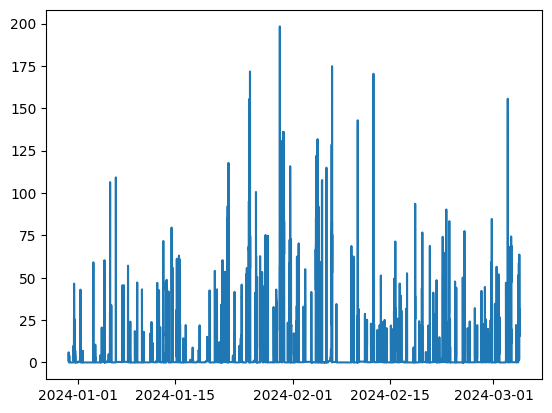

In [196]:
#group by time interval 10m
from turtle import color
import matplotlib.pyplot as plt
#plot speed towards home
plt.plot(df_extracted['speed'])
# plt.plot(df_extracted['distance_from_home'], color='red')


In [197]:
df = df_extracted.resample("1min").mean()
# df = df.reset_index(drop=True)
df["consumed_heat_kJ"] = (
    df["water_flow_L_per_minute_mean"]
    * (df["water_temperature_mean"] - 10)
    * 4.186
    * 0.6
)
df = df.groupby(pd.Grouper(freq="30T"))
df = df.agg(
    {
        "consumed_heat_kJ": "sum",
        "water_flow_L_per_minute_mean": "mean",
        "water_temperature_mean": "mean",
        "outside_temperature_mean": "mean",
        "outside_humidity_mean": "mean",
        "outside_wind_speed_mean": "mean",
        "device_presence_distinct_count": "mean",
        "speed": "mean",
        "distance_from_home": "mean",
        
    }
)
df["consumed_heat_kWh"] = df["consumed_heat_kJ"] / 3600
df = df.drop(columns=["consumed_heat_kJ"])

freq = 0.5
freq_hour = f"{freq}H"

df.index = pd.to_datetime(df.index)

df.loc[:, "weekday"] = df.index.weekday
df.loc[:, "hour"] = df.index.hour
df.loc[:, "minute"] = df.index.minute

# delete rows with weekday nan
df = df.dropna(subset=["weekday"])
df["consumed_heat_kWh"] = df["consumed_heat_kWh"].fillna(0)

# fill na in df based on column
df["temperature"] = df[f"outside_temperature_mean"].fillna(method="ffill")
df["humidity"] = df[f"outside_humidity_mean"].fillna(method="ffill")
df["wind_speed"] = df[f"outside_wind_speed_mean"].fillna(method="ffill")
df["count"] = df["device_presence_distinct_count"].fillna(method="ffill")

# add to column 'consumed_heat_kWh' 1,25/6 to each row
df["consumed_heat_kWh"] += 1.25 / (24 // freq)

window = 6

df["longtime_mean"] = (
    df["consumed_heat_kWh"]
    .rolling(window=window, min_periods=1, center=True)
    .mean()
)
df["longtime_std"] = (
    df["consumed_heat_kWh"].rolling(window=window, min_periods=1).std()
)
df["longtime_min"] = (
    df["consumed_heat_kWh"].rolling(window=window, min_periods=1).min()
)
df["longtime_max"] = (
    df["consumed_heat_kWh"].rolling(window=window, min_periods=1).max()
)
df["longtime_median"] = (
    df["consumed_heat_kWh"].rolling(window=window, min_periods=1).median()
)
df["longtime_skew"] = (
    df["consumed_heat_kWh"].rolling(window=window, min_periods=1).skew()
)

# drop consumed_heat_kWh
df = df.drop(columns=["consumed_heat_kWh"])

df["longtime_std"] = df["longtime_std"].fillna(method="ffill")
df["longtime_std"] = df["longtime_std"].fillna(method="ffill")
df["longtime_skew"] = df["longtime_mean"].fillna(method="ffill")

# transform weekday, minute, hour to sin cos
df["weekday_sin"] = np.sin(2 * df["weekday"] * np.pi / 7)
df["weekday_cos"] = np.cos(2 * df["weekday"] * np.pi / 7)

df["hour_sin"] = np.sin(2 * df["hour"] * np.pi / 24)
df["hour_cos"] = np.cos(2 * df["hour"] * np.pi / 24)

df["minute_sin"] = np.sin(2 * df["minute"] * np.pi / 60)
df["minute_cos"] = np.cos(2 * df["minute"] * np.pi / 60)

# df = df[['temperature','humidity','wind_speed','count','weekday_sin','weekday_cos','hour_sin', 'hour_cos', 'longtime_mean', 'minute_sin', 'minute_cos']]
df = df[
    [
        'longtime_mean',
        "distance_from_home",
        "speed",
        "weekday_sin",
        "weekday_cos",
        "hour_sin",
        "hour_cos",
        "minute_sin",
        "minute_cos",
        # "humidity",
        # "wind_speed",
        # "temperature", 
    ]
]

print(df)

df = df.dropna()

# extract datetimes from index
datetimes = df.index



                           longtime_mean  distance_from_home  speed  \
2023-12-29 00:00:00+00:00       0.026042                 NaN    NaN   
2023-12-29 00:30:00+00:00       0.026042                 NaN    NaN   
2023-12-29 01:00:00+00:00       0.026042                 NaN    NaN   
2023-12-29 01:30:00+00:00       0.026042                 NaN    NaN   
2023-12-29 02:00:00+00:00       0.026042                 NaN    NaN   
...                                  ...                 ...    ...   
2024-03-04 21:30:00+00:00       0.026042                 NaN    NaN   
2024-03-04 22:00:00+00:00       0.026042                 NaN    NaN   
2024-03-04 22:30:00+00:00       0.026042                 NaN    NaN   
2024-03-04 23:00:00+00:00       0.026042                 NaN    NaN   
2024-03-04 23:30:00+00:00       0.026042                 NaN    NaN   

                           weekday_sin  weekday_cos  hour_sin  hour_cos  \
2023-12-29 00:00:00+00:00    -0.433884    -0.900969  0.000000  1.000000 

In [198]:
df = df.reset_index(drop=True)

df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]


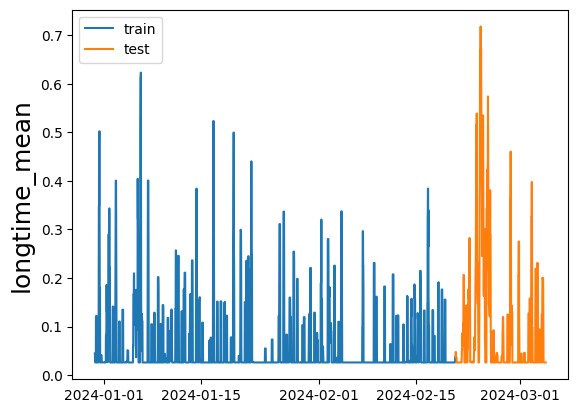

In [199]:
predicted_column = 'longtime_mean'
plt.plot(datetimes[:int(df_train.shape[0])],df_train[predicted_column])
plt.plot(datetimes[-int(df_test.shape[0]):],df_test[predicted_column])
plt.ylabel(predicted_column,fontsize=18)
plt.legend(['train','test'])
plt.show()


## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

In [200]:
from sklearn.preprocessing import RobustScaler

df_train_norm = df_train.copy()
df_test_norm = df_test.copy()

scaler = RobustScaler()

# df_train_norm.loc[:,predicted_column:] = scaler.fit_transform(df_train.loc[:,predicted_column:])
# df_test_norm.loc[:,predicted_column:] = scaler.transform(df_test.loc[:,predicted_column:])
df_train_norm[df_train.columns] = scaler.fit_transform(df_train)
df_test_norm[df_train.columns] = scaler.transform(df_test)


df_train_norm.head()


,longtime_mean,distance_from_home,speed,weekday_sin,weekday_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0.417003,-0.927734,10.579132,-0.62349,-1.638616e-16,-0.612372,-0.353553,0.000000e+00,0.0
1,0.417003,-0.908494,1.063317,-0.62349,-1.638616e-16,-0.612372,-0.353553,5.665539e-16,-1.0
2,0.416908,-0.907742,0.176764,-0.62349,-1.638616e-16,-0.683013,-0.183013,0.000000e+00,0.0
3,-0.000042,-0.907001,0.176761,-0.62349,-1.638616e-16,-0.683013,-0.183013,5.665539e-16,-1.0
4,-0.000042,-0.914262,4.565181,-0.62349,-1.638616e-16,-0.707107,0.000000,0.000000e+00,0.0


<AxesSubplot:>

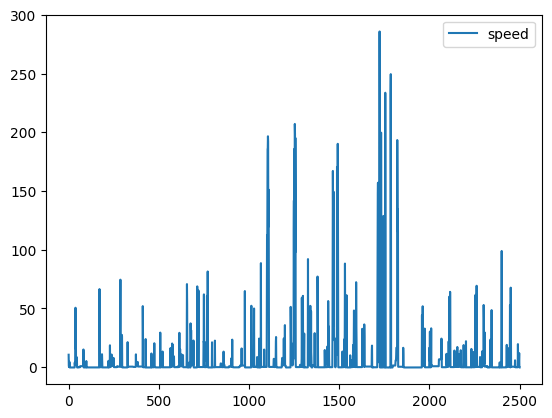

In [201]:
df_train_norm.plot(y='speed')

<AxesSubplot:>

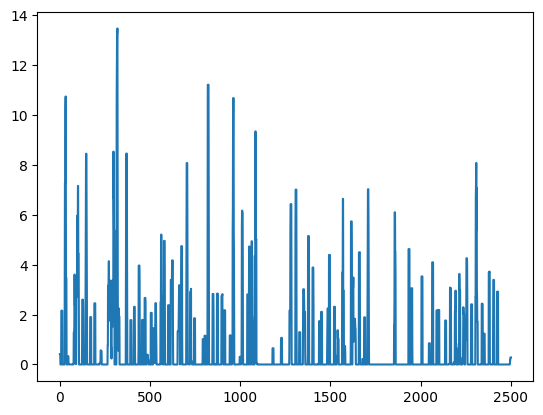

In [202]:
df_train_norm['longtime_mean'].plot()


<AxesSubplot:>

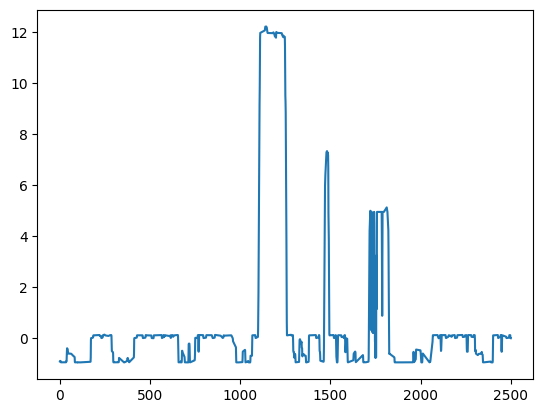

In [203]:
df_train_norm['distance_from_home'].plot()


## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [204]:
def mul_generator(dataframe, target_names, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    data = dataframe.values
    data = data.astype(np.float32)
    
    # Get the column indices for the target names
    target_indices = [dataframe.columns.get_loc(target_name) for target_name in target_names]
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        
        # Modify targets array to accommodate multiple target columns
        targets = np.zeros((len(rows), len(target_indices)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            
            # Assign values for each target column
            for k, target_indx in enumerate(target_indices):
                targets[j][k] = data[rows[j] + delay][target_indx]
                
        yield samples, targets


## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [205]:
#use previous 450 samples to predict next target ('pollution') samples

predicted_columns = ['longtime_mean', 'distance_from_home', 'speed']

lookback = 5
batch_size = 3
delay = 1
train_gen = mul_generator(dataframe = df_train_norm, 
                      target_names = predicted_columns, 
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = int(df_train.shape[0]*0.8),
                      step = 1,
                      shuffle = True,
                      batch_size = batch_size)

valid_gen = mul_generator(dataframe = df_train_norm, 
                      target_names = predicted_columns, 
                      lookback = lookback,
                      delay = delay,
                      min_index = int(df_train.shape[0]*0.8),
                      max_index = None,
                      step = 1,
                      shuffle = False,
                      batch_size = batch_size)

In [206]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = int((df_train_norm.shape[0]*0.1 - lookback) // batch_size)
print('validation_steps = ', val_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
train_steps = int((df_train_norm.shape[0]*0.9 - lookback) // batch_size)
print('train_steps = ', train_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
test_steps = int((df_test_norm.shape[0] - lookback) // batch_size)
print('test_steps = ', test_steps)
#7,80,21

validation_steps =  81
train_steps =  748
test_steps =  206


In [207]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Create LSTM model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU
- can also use lightwieght GRU layers

In [208]:
from keras.layers import LSTM
from keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf



model = Sequential()
model.add(tf.keras.Input(shape=(None, df_train.shape[1])))
model.add(tf.keras.layers.Conv1D(filters=6, kernel_size=5, activation='relu'))
model.add(LSTM(72, return_sequences=True, activation='relu'))
model.add(LSTM(6, return_sequences=False, activation='relu'))
model.add(Dense(3))




## Fit the Model
- to increase the modeling speed, replace the LSTM model with CuDNNLSTM and train on a GPU

In [209]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

callbacks = [EarlyStopping(monitor='loss', min_delta = 0, patience=10, verbose=2, mode='auto', restore_best_weights=True),
             ModelCheckpoint(filepath='lstm_model.keras', monitor='val_loss', save_best_only=True)]

model.compile(loss='mae', optimizer='adam')
# history = model.fit(train_gen, epochs=50, batch_size=72, validation_data=valid_gen, verbose=2, shuffle=False, use_multiprocessing=True)

history = model.fit(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=70,
                              shuffle=False,
                              validation_data=valid_gen,
                              validation_steps=val_steps,
                              callbacks = callbacks)

Epoch 1/70


748/748 [==============================] - 2s 2ms/step - loss: 3.0696 - val_loss: 1.1247
Epoch 2/70
748/748 [==============================] - 1s 2ms/step - loss: 3.2221 - val_loss: 1.5305
Epoch 3/70
748/748 [==============================] - 1s 2ms/step - loss: 2.8166 - val_loss: 0.9801
Epoch 4/70
748/748 [==============================] - 1s 2ms/step - loss: 3.0676 - val_loss: 1.4028
Epoch 5/70
748/748 [==============================] - 1s 1ms/step - loss: 2.7239 - val_loss: 1.0850
Epoch 6/70
748/748 [==============================] - 1s 1ms/step - loss: 2.7574 - val_loss: 1.2409
Epoch 7/70
748/748 [==============================] - 1s 2ms/step - loss: 2.5596 - val_loss: 1.2059
Epoch 8/70
748/748 [==============================] - 1s 2ms/step - loss: 2.2707 - val_loss: 1.2103
Epoch 9/70
748/748 [==============================] - 1s 2ms/step - loss: 2.7795 - val_loss: 1.2068
Epoch 10/70
748/748 [==============================] - 1s 2ms/step - loss: 2.6391 - val_loss: 1.2235
Epoch 11/7

## Get model predictions on df_test
- get (X,y_truth) by calling train_gen using next
- set the batch_size

In [210]:
model = load_model('lstm_model.keras', custom_objects={'r2_keras': r2_keras})

In [211]:
# append a value to all rows in longtimemean column zeroes

test_gen = mul_generator(dataframe = df_test_norm, 
                      target_names = predicted_columns, 
                     lookback = lookback,
                     delay = delay,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = df_test.shape[0])
(X, y_truth) = next(test_gen)
y_pred = model.predict(X)


20/20 [==============================] - 0s 767us/step


In [212]:
y_pred_longtime_mean = y_pred[:,0]
y_pred_distance_from_home = y_pred[:,1]
y_pred_speed = y_pred[:,2]

y_truth_longtime_mean = y_truth[:,0]
y_truth_distance_from_home = y_truth[:,1]
y_truth_speed = y_truth[:,2]


len_columns = len(df_train_norm.columns)
num_features = len_columns - 3

print("Shape of y_pred:", y_pred.shape)

y_pred_expanded = np.zeros((y_pred.shape[0], len_columns))
print(y_pred)
y_pred_expanded[:, 0] = y_pred_longtime_mean
y_pred_expanded[:, 1] = y_pred_distance_from_home
y_pred_expanded[:, 2] = y_pred_speed
y_pred_inverse = scaler.inverse_transform(y_pred_expanded)
# Extract the first column (assuming the first column contains the predictions for the first target variable)

y_truth_expanded = np.zeros((y_truth.shape[0], len_columns))
y_truth_expanded[:, 0] = y_truth_longtime_mean
y_truth_expanded[:, 1] = y_truth_distance_from_home
y_truth_expanded[:, 2] = y_truth_speed

y_truth_inverse = scaler.inverse_transform(y_truth_expanded)


Shape of y_pred: (618, 3)
[[-0.03581454  0.06090214  0.03983743]
 [-0.05898144 -0.08834936 -0.03256266]
 [ 0.03855668  0.02267011 -0.11446989]
 ...
 [-0.00253666 -0.4954433   0.3901435 ]
 [-0.0195492  -0.44590598  0.3572625 ]
 [-0.05076281 -0.4937827   0.3336742 ]]


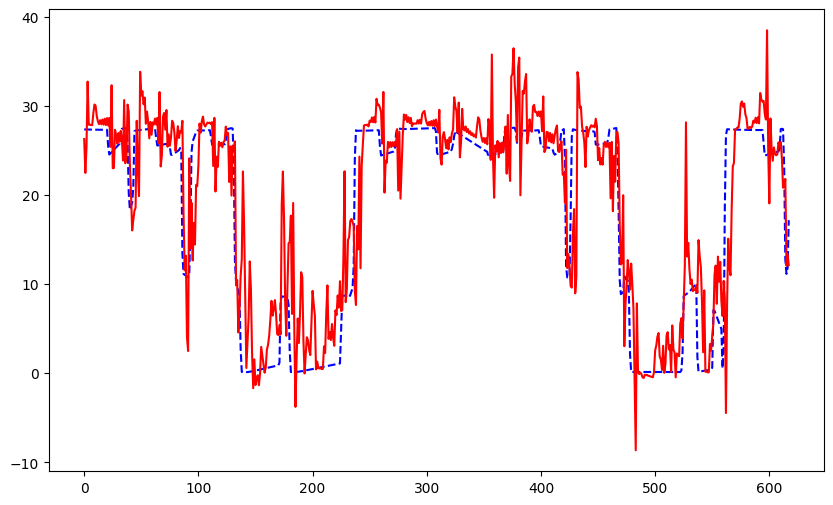

In [213]:
#plot the results
y_pred_1 = y_pred_inverse[:, 1]
y_truth_1 = y_truth_inverse[:, 1]
y_pred_2 = y_pred_inverse[:, 2]
y_truth_2 = y_truth_inverse[:, 2]
y_pred_3 = y_pred_inverse[:, 0]
y_truth_3 = y_truth_inverse[:, 0]
plt.figure(figsize=(10, 6))
plt.plot(y_truth_1, label='True', color='blue', linestyle='dashed')
plt.plot(y_pred_1, label='Predicted', color='red')
# plt.plot(y_truth_2, label='True', color='red', linestyle='dashed')
# plt.plot(y_pred_2, label='Predicted', color='red')
# plt.plot(y_truth_3, label='True', color='green', linestyle='dashed')
# plt.plot(y_pred_3, label='True', color='green')

(618,)
R2 =  0.8002486191840973
mse =  26.7762973101477
rmse =  5.174581848820995


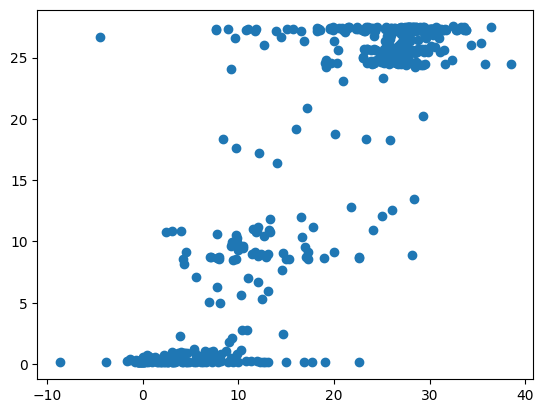

In [214]:
from scipy import stats
from sklearn.metrics import mean_squared_error
print(y_pred_1.shape)
slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_1,y=y_truth_1)
mse = mean_squared_error(y_true=y_truth_1, y_pred=y_pred_1, squared=True)
rmse = mean_squared_error(y_true=y_truth_1, y_pred=y_pred_1, squared=False)


print('R2 = ',r_value*r_value)
print('mse = ',mse)
print('rmse = ',rmse)

plt.scatter(x=y_pred_1,y=y_truth_1)

In [222]:
from datetime import timedelta
import pandas as pd

# Define the indices for the different predictions and truths
LONGTIME_MEAN_INDEX = 0
DISTANCE_FROM_HOME_INDEX = 1
SPEED_INDEX = 2

number_of_predictions = 48
df_all = df_test_norm.copy()[:-number_of_predictions]
df_all_begin = df_test_norm.copy()[:-number_of_predictions]
df_true = df_test_norm.copy()[-number_of_predictions:]
print(type(df_all))
forecast_future = pd.DataFrame()
left_time_interval = pd.to_datetime("2024-3-05 00:00:00")
current_forecast_begin_date = left_time_interval
# prediction for next 6 hours
for i in range(0, number_of_predictions):
    print("-----")

    df_predict = pd.DataFrame({"datetime": [current_forecast_begin_date]})
    df_predict["longtime_mean"] = 0
    df_predict["distance_from_home"] = 0
    df_predict["speed"] = 0
    df_predict["weekday_sin"] = np.sin(
        2 * np.pi * df_predict["datetime"].dt.weekday / 7
    )
    df_predict["weekday_cos"] = np.cos(
        2 * np.pi * df_predict["datetime"].dt.weekday / 7
    )
    df_predict["hour_sin"] = np.sin(2 * np.pi * df_predict["datetime"].dt.hour / 24)
    df_predict["hour_cos"] = np.cos(2 * np.pi * df_predict["datetime"].dt.hour / 24)
    df_predict["minute_sin"] = np.sin(2 * np.pi * df_predict["datetime"].dt.minute / 60)
    df_predict["minute_cos"] = np.cos(2 * np.pi * df_predict["datetime"].dt.minute / 60)
    # delete column datetime
    df_predict = df_predict.drop(columns="datetime")
    # concar df_all and df_predict

    # df_all = pd.concat([df_all, df_predict], axis=0)
    df_all = df_all.reset_index(drop=True)
    print(len(df_all))

    df_predict_norm = df_all.copy()
    df_predict_norm[df_all.columns] = scaler.transform(df_all)
    # create predict df with values

    predict_gen = mul_generator(
        dataframe=df_predict_norm,
        target_names=predicted_columns,
        lookback=lookback,
        delay=delay,
        min_index=0,
        max_index=None,
        step=1,
        shuffle=False,
        batch_size=df_predict.shape[0],
    )

    (X, y_truth) = next(predict_gen)

    y_pred = model.predict(X, verbose=2)

    # Extract the individual predictions and truths
    y_pred_interested = [
        y_pred[:, LONGTIME_MEAN_INDEX],
        y_pred[:, DISTANCE_FROM_HOME_INDEX],
        y_pred[:, SPEED_INDEX],
    ]

    # Assuming scaler is defined elsewhere
    # Expand and inverse transform predictions
    y_pred_expanded = np.zeros((y_pred.shape[0], len_columns))
    y_pred_expanded[:, LONGTIME_MEAN_INDEX] = y_pred_interested[LONGTIME_MEAN_INDEX]
    y_pred_expanded[:, DISTANCE_FROM_HOME_INDEX] = y_pred_interested[
        DISTANCE_FROM_HOME_INDEX
    ]
    y_pred_expanded[:, SPEED_INDEX] = y_pred_interested[SPEED_INDEX]
    y_pred_inverse = scaler.inverse_transform(y_pred_expanded)
    print(len(y_pred_inverse))
    # extract first three columns
    y_pred_interested_inv = (
        y_pred_inverse[:, 0],
        y_pred_inverse[:, 1],
        y_pred_inverse[:, 2],
    )

    len_y_pred = len(y_pred_interested_inv[0])

    # set df_all last len_df_predict values to y_pred_inv
    df_all.iloc[-len_y_pred:, LONGTIME_MEAN_INDEX] = y_pred_interested_inv[
        LONGTIME_MEAN_INDEX
    ]
    df_all.iloc[-len_y_pred:, DISTANCE_FROM_HOME_INDEX] = y_pred_interested_inv[
        DISTANCE_FROM_HOME_INDEX
    ]
    df_all.iloc[-len_y_pred:, SPEED_INDEX] = y_pred_interested_inv[SPEED_INDEX]

    df_all = df_all[len_y_pred:]

    forecast_future = pd.concat(
        [forecast_future, df_all[predicted_columns].iloc[-len_y_pred:]], axis=0
    )
    forecast_future = forecast_future.reset_index(drop=True)

    current_forecast_begin_date += timedelta(hours=0.5)
print(forecast_future)

# last 48 values

<class 'pandas.core.frame.DataFrame'>
-----
577
1/1 - 0s - 12ms/epoch - 12ms/step
1
-----
576
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
575
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
574
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
573
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
572
1/1 - 0s - 24ms/epoch - 24ms/step
1
-----
571
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
570
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
569
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
568
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
567
1/1 - 0s - 11ms/epoch - 11ms/step
1
-----
566
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
565
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
564
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
563
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
562
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
561
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
560
1/1 - 0s - 9ms/epoch - 9ms/step
1
-----
559
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
558
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
557
1/1 - 0s - 10ms/epoch - 10ms/step
1
-----
556
1/1 - 

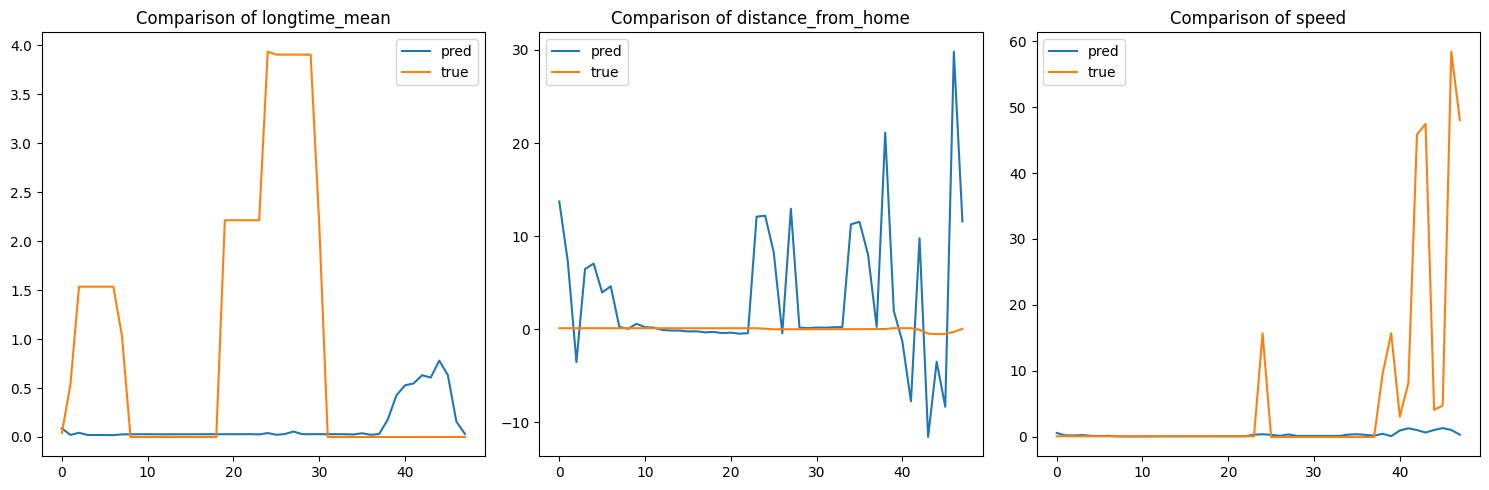

In [223]:
# plot the results in 3 plots, in one will be longtime from df_true and from forecast_future
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
forecast_future_plot = forecast_future.reset_index(drop=True)
df_true_plot = df_true.reset_index(drop=True)
# Plot each comparison
for i, col in enumerate(predicted_columns):
    axs[i].plot(forecast_future_plot[col], label='pred')
    axs[i].plot(df_true_plot[col], label='true')
    axs[i].set_title(f'Comparison of {col}')
    axs[i].legend()

plt.tight_layout()
plt.show()

### Need to remove normalization
- since we preformed normlization transform on 7 cols of dataframe, we need to add dummy colums to preds

### Get R2 for this prediction

In [217]:
print(y_truth.shape)

(1, 3)


In [218]:
print(y_pred.shape)

(1, 3)


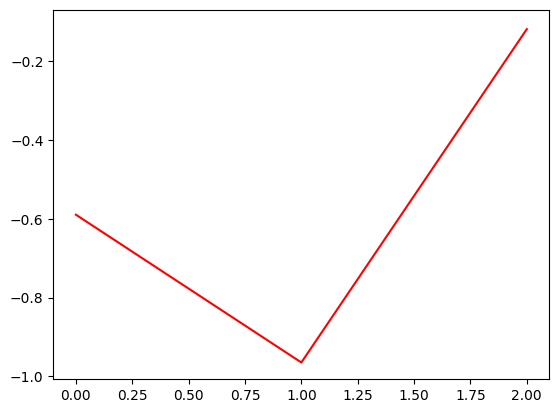

In [219]:
#plot y_truth and y_pred
plt.plot(y_truth[0], color = 'red', label = 'Real data')

plt.plot(y_pred)


[  0  24  48  72  96 120 144 168 192 216 240 264 288 312 336 360 384 408
 432 456 480 504 528 552 576 600 624]


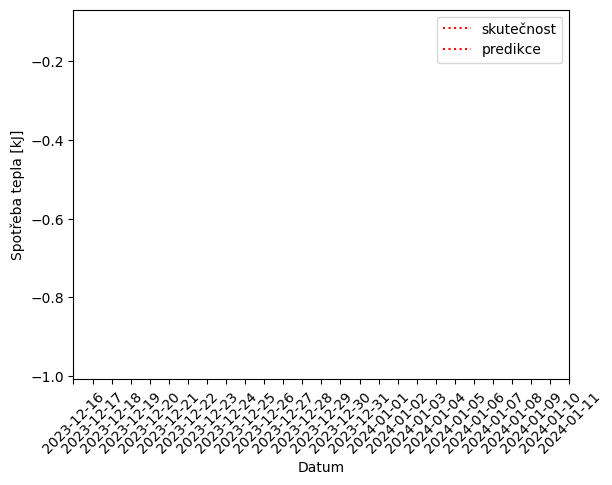

In [220]:

plt.plot(y_truth, color = 'red', linestyle='dotted')
plt.plot(y_pred, color = 'blue', linestyle='dotted')
# change x ticks to dates
print(np.arange(0, df_test.shape[0], step=24))
# create list of dates by 1 hour from 2023-11-01 00:00:00 to 2023-11-30 23:00:00
start = pd.to_datetime('2023-12-16 19:00:00')
end = start + pd.Timedelta(hours=df_test.shape[0])
dates = pd.date_range(start, end, freq='1H')

# transform dates to format MM-DD HH
dates = dates.strftime('%Y-%m-%d')
# set xticks to dates
plt.xticks(np.arange(0, df_test.shape[0], step=24), dates[np.arange(0, df_test.shape[0], step=24)], rotation=45)

#add legend
plt.legend(['skutečnost','predikce'])

# add x and y label
plt.xlabel('Datum')
plt.ylabel('Spotřeba tepla [kJ]')


plt.show()

## Let's try the evaluate_generator in keras

In [221]:
(_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)
print('R2 = ',r2)


/var/folders/8t/gl5rl9r94nl0wvx62zrp3pcr0000gn/T/ipykernel_16748/2211671762.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  (_,r2) = model.evaluate_generator(generator=test_gen,steps=1,workers=1)


TypeError: cannot unpack non-iterable float object